In [2]:
import matplotlib.pyplot as plt

def relplot(data, x, y, filename,
             col=None, hue=None, style=None,
             title=None, ylim=None,
             caption=None, X=None, Y=None,
             save=True, show=False):
    filename += '.png'
    plot = sns.relplot(data=data, x=x, y=y, col=col, hue=hue, style=style, kind='line')
    if title:
        plot.fig.subplots_adjust(top=0.9)
        plot.fig.suptitle(title)
    if X:
        plot.set_xlabels(X)
    if Y:
        plot.set_ylabels(Y)
    if ylim is not None:
        plot.set(ylim=ylim)

    if save:
        plot.savefig(f"{figures_dir}/{filename}")
    if show:
        plt.show()

    if not caption:
        caption = filename

    print(f'''
\\begin{{figure}}[h]
    \centering
    \includegraphics[width=0.25\\textwidth]{{{filename}}}
    \caption{{{caption}}}
    \label{{fig:{filename}}}
\end{{figure}}
''')

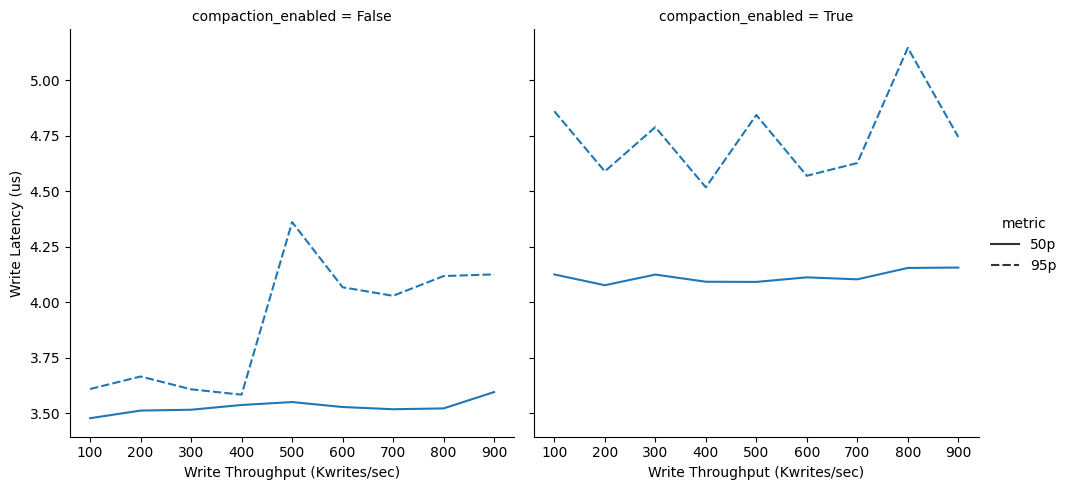


\begin{figure}[h]
    \centering
    \includegraphics[width=0.25\textwidth]{compaction_write.png}
    \caption{keylen: 4, vlen: 4, nitems: 10_000, writing 10Kkeys/sec, uniform distrib, max_runs_per_level: 3, mem_segment_len: 10K, ro_lag_interval: 8K, flush_interval: 1K, 10second sample for each average latency measurement}
    \label{fig:compaction_write.png}
\end{figure}



In [17]:
# writes

import sys
sys.path.append('..')
from utils import *
from distributions import Uniform, Zipfian, HotSet
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathReplica


def measure_compaction(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    writes_per_secs = list(range(100_000, 1000_000, 100_000))

    for writes_per_sec in writes_per_secs:
        latencies = []
        for i in range(seconds):
            # pick key/values to write
            with Timer() as latency:
                for _ in range(writes_per_sec):
                    db[keys_set[next(distro)]] = vals_set[next(distro)]
            latency = float(latency)
            avg_latency = latency / writes_per_sec
            # if latency < 1:
            #     sleep(1 - latency)
            latencies.append(avg_latency)

        res.append({'metric': '50p', 'value': percentile(latencies, 50), 'writes_per_sec': writes_per_sec/1000})
        res.append({'metric': '95p', 'value': percentile(latencies, 95), 'writes_per_sec': writes_per_sec/1000})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [1]}],
    [HybridLog], [{
        'max_runs_per_level': [3],
        'mem_segment_len': [10_000],
        'ro_lag_interval': [8_000],
        'flush_interval': [1_000],
        'hash_index': ['dict'],
        'compaction_enabled': [True, False],
        'replica': [None]
    }],
    [measure_compaction], {}
)


data = df[['compaction_enabled', 'writes_per_sec', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['50p', '95p'])]
data['value'] = data['value'] * 1000000   #us

relplot(data, 'writes_per_sec', 'value', 'compaction_write',
         style='metric',
         col='compaction_enabled',
         X='Write Throughput (Kwrites/sec)', Y='Write Latency (us)',
         caption='keylen: 4, vlen: 4, nitems: 10_000, uniform distrib, max_runs_per_level: 3, mem_segment_len: 10K, ro_lag_interval: 8K, flush_interval: 1K, 10second sample for each average latency measurement',
         save=True, show=True)


In [ ]:
# reads
import sys
sys.path.append('..')
from utils import *
from distributions import Uniform, Zipfian, HotSet
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathReplica

def measure_compaction(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    reads_per_secs = list(range(100_000, 1000_000, 100_000))

    # first populate
    for k, v in zip(keys_set, vals_set):
        db[k] = v

    for reads_per_sec in reads_per_secs:
        latencies = []
        for i in range(seconds):
            with Timer() as latency:
                for _ in range(reads_per_sec):
                    _ = db[keys_set[next(distro)]]
            latency = float(latency)
            avg_latency = latency / reads_per_sec
            # if latency < 1:
            #     sleep(1 - latency)
            latencies.append(avg_latency)

        res.append({'metric': '50p', 'value': percentile(latencies, 50), 'reads_per_sec': reads_per_sec/1000})
        res.append({'metric': '95p', 'value': percentile(latencies, 95), 'reads_per_sec': reads_per_sec/1000})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [1]}],
    [HybridLog], [{
        'max_runs_per_level': [3],
        'mem_segment_len': [10_000],
        'ro_lag_interval': [8_000],
        'flush_interval': [1_000],
        'hash_index': ['dict'],
        'compaction_enabled': [True, False],
        'replica': [None]
    }],
    [measure_compaction], {}
)


data = df[['compaction_enabled', 'reads_per_sec', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['50p', '95p'])]
data['value'] = data['value'] * 1000000   #us

relplot(data, 'reads_per_sec', 'value', 'compaction_read',
         style='metric',
         col='compaction_enabled',
         X='Read Throughput (Kreads/sec)', Y='Read Latency (us)',
         ylim=(1, 1.5),
         caption='keylen: 4, vlen: 4, nitems: 10_000, uniform distrib, max_runs_per_level: 3, mem_segment_len: 10K, ro_lag_interval: 8K, flush_interval: 1K, 10second sample for each average latency measurement',
         save=True, show=True)